In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
%matplotlib inline

import glob
import sklearn
import torch
import torch.nn as nn

In [3]:
files = sorted(glob.glob('data/lstm/*.csv.gz'))

In [4]:
df = pd.concat(map(pd.read_csv, files))

In [5]:
df = df[df.symbol == 'XBTUSD']

In [7]:
# covert to timestamp type
df.timestamp = pd.to_datetime(df.timestamp.str.replace('D', 'T'))

In [8]:
df = df.sort_values('timestamp')

In [9]:
# set index to timestamp
df.set_index('timestamp', inplace=True)

In [10]:
df.head()

,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
timestamp,,,,,,,,,
2020-04-20 00:00:02.998482,XBTUSD,Sell,57,7125.0,MinusTick,c38376c2-d09f-5ba7-30f5-0542e4ea7542,799995,0.008000,57.0
2020-04-20 00:00:03.001833,XBTUSD,Sell,25,7125.0,ZeroMinusTick,e205390b-3fdd-0df1-4d5f-a934d4124b31,350875,0.003509,25.0
2020-04-20 00:00:03.090244,XBTUSD,Sell,3227,7125.0,ZeroMinusTick,68017e6c-3e05-a5c7-c397-e0ef60c07ed3,45290945,0.452909,3227.0
2020-04-20 00:00:03.429719,XBTUSD,Sell,10,7125.0,ZeroMinusTick,95022e39-2e92-da87-1543-ab78b6dcc5fa,140350,0.001404,10.0
2020-04-20 00:00:03.648011,XBTUSD,Sell,18,7125.0,ZeroMinusTick,db8d2723-4c55-eac8-b696-ce1b4df4d4b8,252630,0.002526,18.0


In [56]:
df_vwap = df.groupby(pd.Grouper(freq="1Min")).apply(
    lambda row: np.sum(row.price * row.foreignNotional) / np.sum(row.foreignNotional))

In [57]:
df_vwap

timestamp
2020-04-20 00:00:00    7125.932850
2020-04-20 00:01:00    7121.392883
2020-04-20 00:02:00    7101.023068
2020-04-20 00:03:00    7109.457426
2020-04-20 00:04:00    7114.023479
                          ...     
2020-04-22 23:55:00    7120.261463
2020-04-22 23:56:00    7120.086473
2020-04-22 23:57:00    7122.948857
2020-04-22 23:58:00    7128.706494
2020-04-22 23:59:00    7132.717193
Length: 4320, dtype: float64

In [69]:
df = df_vwap.reset_index()

In [70]:
df.columns

Index(['timestamp', 0], dtype='object')

In [77]:
df.rename({0 : 'price'}, axis=1, inplace=True)

In [79]:
df.shape

(4320, 2)

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

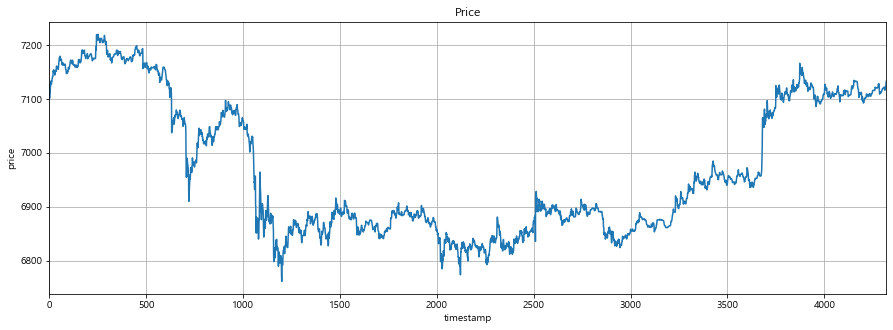

In [82]:
plt.title('Price')
plt.ylabel('price')
plt.xlabel('timestamp')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['price'])

# Data Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train)
val_arr = scaler.transform(df_val)
test_arr = scaler.transform(df_test)

In [83]:
df.columns

Index(['timestamp', 'price'], dtype='object')

In [84]:
all_data = df['price'].values.astype(float)

In [85]:
print(all_data)

[7125.93285037 7121.39288292 7101.02306779 ... 7122.94885677 7128.70649433
 7132.71719334]


In [88]:
len(all_data) * 0.1

432.0

In [89]:
# test 데이터의 크기 지정

test_data_size = 432

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [93]:
print("length of train data : %s" % len(train_data))
print("length of test data : %s" % len(test_data))
print(test_data[:10])

length of train data : 3888
length of test data : 432
[7147.43955003 7149.00580814 7148.34103812 7145.32729912 7143.69732216
 7141.99903275 7140.74272053 7137.7169895  7132.98061297 7128.45268853]


In [94]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [95]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[0.59125371]
 [0.57144658]
 [0.48257642]
 [0.51937414]
 [0.53929508]]
[[0.66656225]
 [0.66828749]
 [0.71687424]
 [0.73276037]
 [0.70571477]]


In [96]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [102]:
# 몇개 씩 묶어서 학습을 할 것인가를 설정
train_window = 54

In [103]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [104]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [105]:
train_inout_seq[:5]

[(tensor([0.5913, 0.5714, 0.4826, 0.5194, 0.5393, 0.5319, 0.5628, 0.6074, 0.6159,
          0.6221, 0.5943, 0.5953, 0.6081, 0.6138, 0.6207, 0.6363, 0.6487, 0.6582,
          0.6574, 0.6576, 0.6804, 0.7045, 0.6954, 0.7125, 0.7031, 0.7077, 0.6979,
          0.6958, 0.6862, 0.6705, 0.6819, 0.6998, 0.6980, 0.7067, 0.6985, 0.7039,
          0.7121, 0.7376, 0.7436, 0.7419, 0.7399, 0.7346, 0.7267, 0.7265, 0.7244,
          0.7189, 0.7162, 0.7168, 0.7395, 0.7740, 0.7756, 0.7942, 0.8091, 0.8082]),
  tensor([0.8131])),
 (tensor([0.5714, 0.4826, 0.5194, 0.5393, 0.5319, 0.5628, 0.6074, 0.6159, 0.6221,
          0.5943, 0.5953, 0.6081, 0.6138, 0.6207, 0.6363, 0.6487, 0.6582, 0.6574,
          0.6576, 0.6804, 0.7045, 0.6954, 0.7125, 0.7031, 0.7077, 0.6979, 0.6958,
          0.6862, 0.6705, 0.6819, 0.6998, 0.6980, 0.7067, 0.6985, 0.7039, 0.7121,
          0.7376, 0.7436, 0.7419, 0.7399, 0.7346, 0.7267, 0.7265, 0.7244, 0.7189,
          0.7162, 0.7168, 0.7395, 0.7740, 0.7756, 0.7942, 0.8091, 0.8082, 0

# Creating LSTM Model

In [106]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [107]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [108]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


# Training the Model

In [ ]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')